In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df_processed = pd.read_csv('processed_churn.csv', sep=',')

Разделим данные для моделирования:

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.utils import class_weight

# Разделяем данные на признаки и целевую переменную
X = df_processed.drop(['Exited', 'Geo_France'],axis=1)
y = df_processed['Exited']

print(" РАЗМЕРНОСТИ ДАННЫХ:")
print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"\nРаспределение классов в y:")
print(y.value_counts())
print(f"Процент оттока: {y.mean()*100:.1f}%")

# Разделение на train/test с сохранением распределения классов
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n РАЗДЕЛЕНИЕ НА TRAIN/TEST:")
print(f"Train: {X_train.shape} ({(1-0.2)*100:.0f}% данных)")
print(f"Test: {X_test.shape} (20% данных)")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в test:")
print(y_test.value_counts(normalize=True))

# Масштабирование числовых признаков 
scaler = StandardScaler()

# Список числовых признаков для масштабирования
numeric_features_for_scaling = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

print(f"\n МАСШТАБИРОВАНИЕ ПРИЗНАКОВ: {numeric_features_for_scaling}")

# Масштабируем train и test отдельно (чтобы избежать data leakage)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for feature in numeric_features_for_scaling:
    if feature in X_train.columns:
        scaler.fit(X_train[[feature]])
        X_train_scaled[feature] = scaler.transform(X_train[[feature]])
        X_test_scaled[feature] = scaler.transform(X_test[[feature]])

print("Масштабирование выполнено")

# Сохраняем имена признаков для интерпретации
feature_names = X_train.columns.tolist()
print(f"\n СПИСОК ПРИЗНАКОВ ({len(feature_names)}):")
for i, feature in enumerate(feature_names, 1):
    print(f"{i:2}. {feature}")

 РАЗМЕРНОСТИ ДАННЫХ:
Признаки (X): (10000, 11)
Целевая переменная (y): (10000,)

Распределение классов в y:
Exited
0    7963
1    2037
Name: count, dtype: int64
Процент оттока: 20.4%

 РАЗДЕЛЕНИЕ НА TRAIN/TEST:
Train: (8000, 11) (80% данных)
Test: (2000, 11) (20% данных)

Распределение классов в train:
Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

Распределение классов в test:
Exited
0    0.7965
1    0.2035
Name: proportion, dtype: float64

 МАСШТАБИРОВАНИЕ ПРИЗНАКОВ: ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
Масштабирование выполнено

 СПИСОК ПРИЗНАКОВ (11):
 1. CreditScore
 2. Gender
 3. Age
 4. Tenure
 5. Balance
 6. NumOfProducts
 7. HasCrCard
 8. IsActiveMember
 9. EstimatedSalary
10. Geo_Germany
11. Geo_Spain


Обучим и сравним качество различных моделей:


 ОБУЧЕНИЕ МОДЕЛИ: Logistic Regression
 Результаты на тестовой выборке:
   Accuracy: 0.8080
   ROC-AUC: 0.7748
   CV ROC-AUC: 0.7628 (+/- 0.0398)
   Время обучения: 0.02 секунд

 Classification Report:
              precision    recall  f1-score   support

     Не ушел       0.82      0.97      0.89      1593
        Ушел       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

 Матрица ошибок:
[[1540   53]
 [ 331   76]]

 ОБУЧЕНИЕ МОДЕЛИ: Random Forest
 Результаты на тестовой выборке:
   Accuracy: 0.8615
   ROC-AUC: 0.8542
   CV ROC-AUC: 0.8502 (+/- 0.0249)
   Время обучения: 1.08 секунд

 Classification Report:
              precision    recall  f1-score   support

     Не ушел       0.87      0.97      0.92      1593
        Ушел       0.77      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg 

,Model,Accuracy,ROC-AUC,CV ROC-AUC Mean,CV ROC-AUC Std,Training Time (s)
2,Gradient Boosting,0.870000,0.870831,0.864758,0.009868,1.122323
4,LightGBM,0.864500,0.860122,0.858382,0.012081,0.192686
1,Random Forest,0.861500,0.854189,0.850239,0.012443,1.076912
3,XGBoost,0.849000,0.832834,0.842882,0.012112,0.134119
0,Logistic Regression,0.808000,0.774826,0.762837,0.019917,0.020470


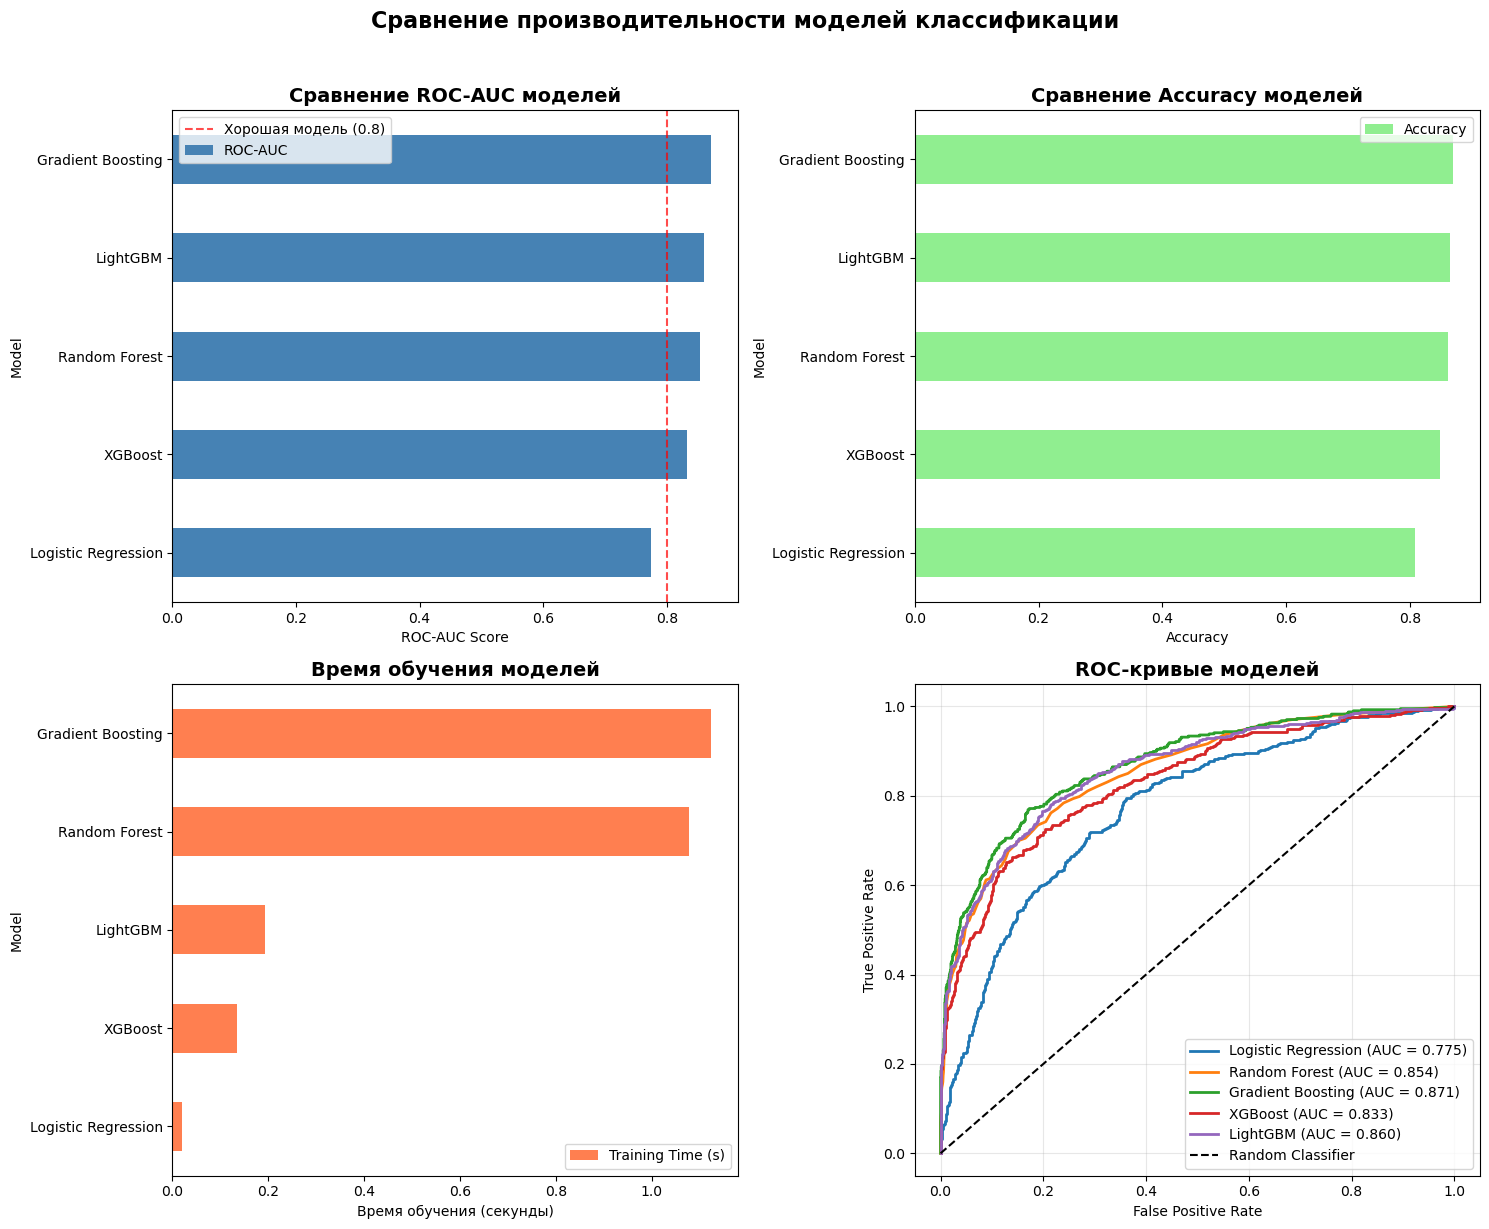

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import time

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}


results = {}
model_times = {}

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f" ОБУЧЕНИЕ МОДЕЛИ: {name}")
    print('='*60)
    
    start_time = time.time()
    
    # Обучение модели
    model.fit(X_train_scaled, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Время выполнения
    training_time = time.time() - start_time
    model_times[name] = training_time
    
    # Метрики
    accuracy = model.score(X_test_scaled, y_test)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Кросс-валидация
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    
    # Сохраняем результаты
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time
    }
    
    # Выводим результаты
    print(f" Результаты на тестовой выборке:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    print(f"   CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"   Время обучения: {training_time:.2f} секунд")
    

    print(f"\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Не ушел', 'Ушел']))
    
    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    print(f" Матрица ошибок:")
    print(cm)

# Создаем DataFrame для сравнения моделей
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] for m in results],
    'CV ROC-AUC Mean': [results[m]['cv_mean'] for m in results],
    'CV ROC-AUC Std': [results[m]['cv_std'] for m in results],
    'Training Time (s)': [results[m]['training_time'] for m in results]
}).sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print(" СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (сортировка по ROC-AUC):")
print("="*80)
display(results_df.style.background_gradient(subset=['ROC-AUC', 'Accuracy'], cmap='YlOrRd'))

# Визуализация сравнения моделей
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC-AUC сравнение
ax1 = axes[0, 0]
results_df.sort_values('ROC-AUC').plot(x='Model', y='ROC-AUC', kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('ROC-AUC Score')
ax1.set_title('Сравнение ROC-AUC моделей', fontsize=14, fontweight='bold')
ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Хорошая модель (0.8)')
ax1.legend()

# 2. Accuracy сравнение
ax2 = axes[0, 1]
results_df.sort_values('Accuracy').plot(x='Model', y='Accuracy', kind='barh', ax=ax2, color='lightgreen')
ax2.set_xlabel('Accuracy')
ax2.set_title('Сравнение Accuracy моделей', fontsize=14, fontweight='bold')

# 3. Время обучения
ax3 = axes[1, 0]
results_df.sort_values('Training Time (s)').plot(x='Model', y='Training Time (s)', kind='barh', ax=ax3, color='coral')
ax3.set_xlabel('Время обучения (секунды)')
ax3.set_title('Время обучения моделей', fontsize=14, fontweight='bold')

# 4. ROC кривые всех моделей
ax4 = axes[1, 1]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = result['roc_auc']
    ax4.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', lw=2)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC-кривые моделей', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.suptitle('Сравнение производительности моделей классификации', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Рассмотрим повнимательнее лучшую модель:

   ЛУЧШАЯ МОДЕЛЬ: Gradient Boosting
   ROC-AUC: 0.8708
   Accuracy: 0.8700

 Детальный анализ лучшей модели: Gradient Boosting


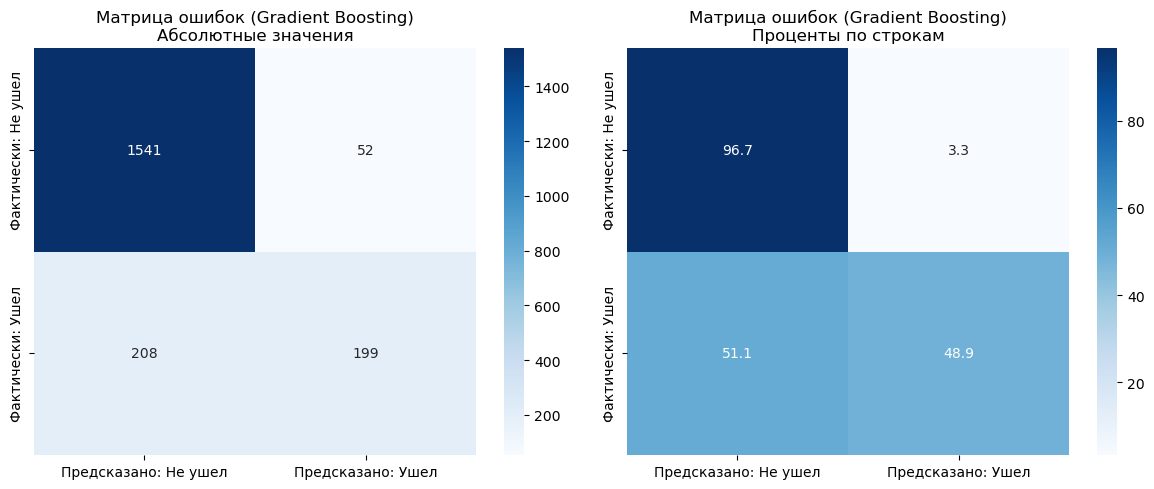

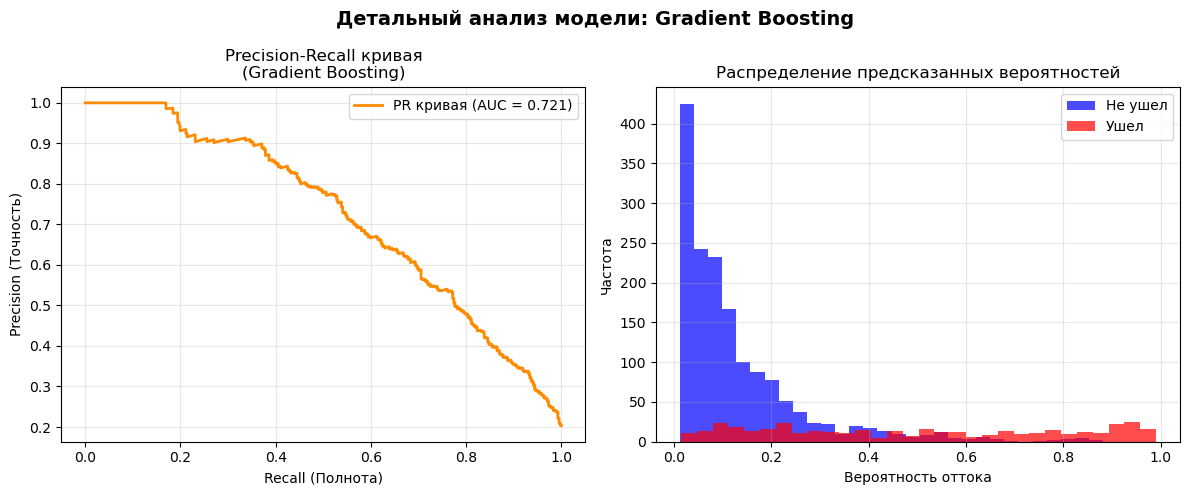


 АНАЛИЗ ОШИБОК МОДЕЛИ:
Всего клиентов в тестовой выборке: 2000
Из них ушли на самом деле: 407 (20.3%)

Матрица ошибок:
True Negative (правильно предсказали 'не ушел'): 1541
False Positive (ошибочно предсказали 'ушел'): 52
False Negative (ошибочно предсказали 'не ушел'): 208
True Positive (правильно предсказали 'ушел'): 199

 БИЗНЕС-МЕТРИКИ:
Recall (полнота): Сколько ушедших клиентов мы нашли? 48.89%
Precision (точность): Из предсказанных 'уйдут', сколько действительно ушли? 79.28%
F1-score: 60.49%


In [13]:
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"   ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")

# Детальный анализ лучшей модели
print(f"\n{'='*60}")
print(f" Детальный анализ лучшей модели: {best_model_name}")
print('='*60)

y_pred_best = results[best_model_name]['y_pred']
y_pred_proba_best = results[best_model_name]['y_pred_proba']

# Матрица ошибок с визуализацией
cm = confusion_matrix(y_test, y_pred_best)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Матрица в абсолютных значениях
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, 
            xticklabels=['Предсказано: Не ушел', 'Предсказано: Ушел'],
            yticklabels=['Фактически: Не ушел', 'Фактически: Ушел'])
ax1.set_title(f'Матрица ошибок ({best_model_name})\nАбсолютные значения', fontsize=12)

# Матрица в процентах
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            xticklabels=['Предсказано: Не ушел', 'Предсказано: Ушел'],
            yticklabels=['Фактически: Не ушел', 'Фактически: Ушел'])
ax2.set_title(f'Матрица ошибок ({best_model_name})\nПроценты по строкам', fontsize=12)

plt.tight_layout()
plt.show()

# Precision-Recall кривая (важно при дисбалансе)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
pr_auc = auc(recall, precision)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Precision-Recall кривая
ax1.plot(recall, precision, color='darkorange', lw=2, label=f'PR кривая (AUC = {pr_auc:.3f})')
ax1.set_xlabel('Recall (Полнота)')
ax1.set_ylabel('Precision (Точность)')
ax1.set_title(f'Precision-Recall кривая\n({best_model_name})', fontsize=12)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Распределение вероятностей для двух классов
ax2.hist(y_pred_proba_best[y_test == 0], bins=30, alpha=0.7, label='Не ушел', color='blue')
ax2.hist(y_pred_proba_best[y_test == 1], bins=30, alpha=0.7, label='Ушел', color='red')
ax2.set_xlabel('Вероятность оттока')
ax2.set_ylabel('Частота')
ax2.set_title('Распределение предсказанных вероятностей', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f'Детальный анализ модели: {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Анализ ошибок модели
print(f"\n АНАЛИЗ ОШИБОК МОДЕЛИ:")
print(f"Всего клиентов в тестовой выборке: {len(y_test)}")
print(f"Из них ушли на самом деле: {y_test.sum()} ({y_test.mean()*100:.1f}%)")
print(f"\nМатрица ошибок:")
print(f"True Negative (правильно предсказали 'не ушел'): {cm[0, 0]}")
print(f"False Positive (ошибочно предсказали 'ушел'): {cm[0, 1]}")
print(f"False Negative (ошибочно предсказали 'не ушел'): {cm[1, 0]}")
print(f"True Positive (правильно предсказали 'ушел'): {cm[1, 1]}")

# Расчет бизнес-метрик
print(f"\n БИЗНЕС-МЕТРИКИ:")
print(f"Recall (полнота): Сколько ушедших клиентов мы нашли? {cm[1, 1] / (cm[1, 0] + cm[1, 1]):.2%}")
print(f"Precision (точность): Из предсказанных 'уйдут', сколько действительно ушли? {cm[1, 1] / (cm[0, 1] + cm[1, 1]):.2%}")
print(f"F1-score: {2 * (cm[1, 1] / (cm[0, 1] + cm[1, 1]) * (cm[1, 1] / (cm[1, 0] + cm[1, 1])) / (cm[1, 1] / (cm[0, 1] + cm[1, 1]) + (cm[1, 1] / (cm[1, 0] + cm[1, 1])))):.2%}")

Проанализируем важность признаков модели:

 ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ МОДЕЛИ: Gradient Boosting


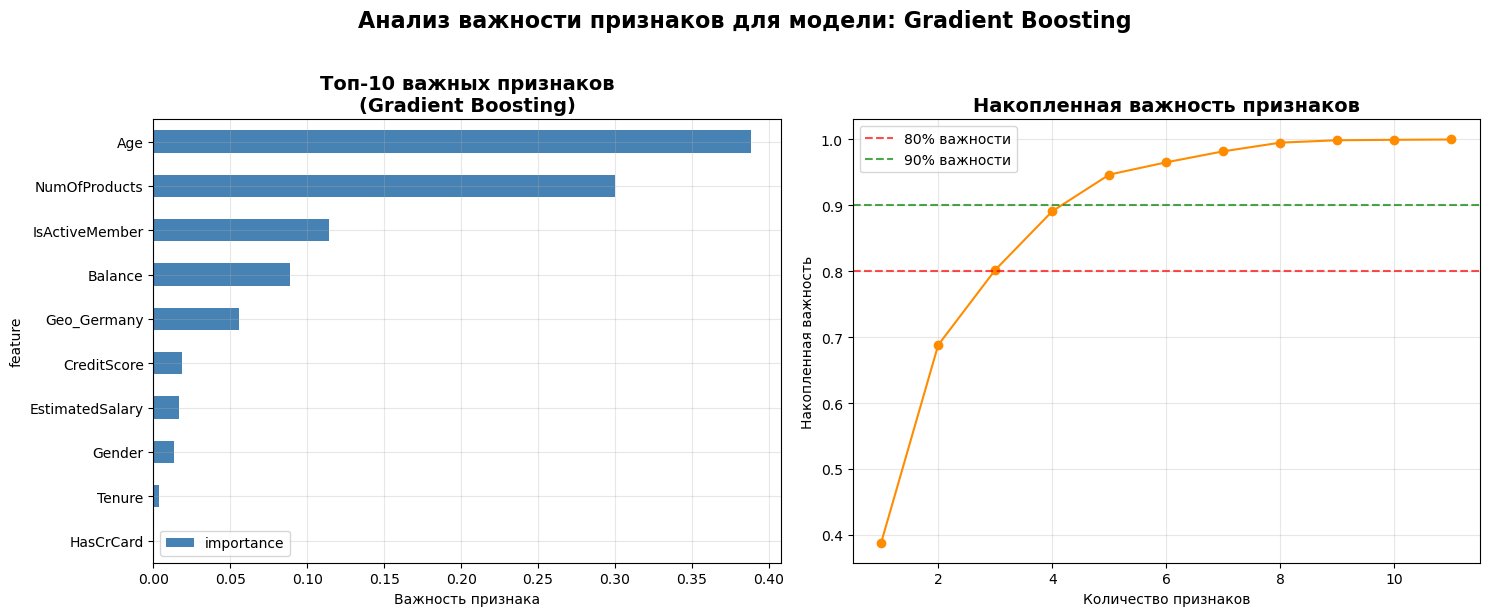

 КЛЮЧЕВЫЕ ВЫВОДЫ ПО ВАЖНОСТИ ПРИЗНАКОВ:
1. Age: 0.3883
2. NumOfProducts: 0.2999
3. IsActiveMember: 0.1139
4. Balance: 0.0891
5. Geo_Germany: 0.0556

 Первые 3 признаков объясняют 80% важности
 Первые 5 признаков объясняют 90% важности


In [38]:
if hasattr(best_model, 'feature_importances_'):
    print(f" ВАЖНОСТЬ ПРИЗНАКОВ ДЛЯ МОДЕЛИ: {best_model_name}")
    
    # Получаем важность признаков
    importances = best_model.feature_importances_
    
    # Создаем DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    feature_importance_df.head(10).sort_values('importance').plot(
        kind='barh', x='feature', y='importance', ax=ax1, color='steelblue'
    )
    ax1.set_xlabel('Важность признака')
    ax1.set_title(f'Топ-10 важных признаков\n({best_model_name})', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Cumulative importance
    feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
    ax2.plot(range(1, len(feature_importance_df) + 1), 
             feature_importance_df['cumulative_importance'], marker='o', linestyle='-', color='darkorange')
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% важности')
    ax2.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% важности')
    ax2.set_xlabel('Количество признаков')
    ax2.set_ylabel('Накопленная важность')
    ax2.set_title('Накопленная важность признаков', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Анализ важности признаков для модели: {best_model_name}', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Выводы
    print(" КЛЮЧЕВЫЕ ВЫВОДЫ ПО ВАЖНОСТИ ПРИЗНАКОВ:")
    print("=" * 50)
    
    top_5_features = feature_importance_df.head(5)
    for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.4f}")
    
    # Сколько признаков объясняют 80% и 90% важности
    n_features_80 = (feature_importance_df['cumulative_importance'] <= 0.8).sum() + 1
    n_features_90 = (feature_importance_df['cumulative_importance'] <= 0.9).sum() + 1
    
    print(f"\n Первые {n_features_80} признаков объясняют 80% важности")
    print(f" Первые {n_features_90} признаков объясняют 90% важности")
    
elif hasattr(best_model, 'coef_'):
    # Для линейных моделей (например, логистической регрессии)
    print(f" КОЭФФИЦИЕНТЫ МОДЕЛИ: {best_model_name}")
    
    coefficients = best_model.coef_[0]
    
    # Создаем DataFrame
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=False)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    coef_df.head(10).sort_values('coefficient').plot(
        kind='barh', x='feature', y='coefficient', color=['red' if x < 0 else 'green' for x in coef_df.head(10)['coefficient']]
    )
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.xlabel('Коэффициент')
    plt.title(f'Топ-10 признаков по абсолютному значению коэффициентов\n({best_model_name})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n ИНТЕРПРЕТАЦИЯ КОЭФФИЦИЕНТОВ:")
    print("-" * 40)
    print("Положительные коэффициенты увеличивают вероятность оттока")
    print("Отрицательные коэффициенты уменьшают вероятность оттока")
    
    top_positive = coef_df[coef_df['coefficient'] > 0].head(3)
    top_negative = coef_df[coef_df['coefficient'] < 0].head(3)
    
    print(f"\n Топ-3 признака, увеличивающих отток:")
    for _, row in top_positive.iterrows():
        print(f"   {row['feature']}: +{row['coefficient']:.4f}")
    
    print(f"\n Топ-3 признака, уменьшающих отток:")
    for _, row in top_negative.iterrows():
        print(f"   {row['feature']}: {row['coefficient']:.4f}")

Recall оказался слишком мал. Попробуем это исправить оптимизацией гиперпараметров и уменьшением порога в 0.5:

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

print(" ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ GRADIENT BOOSTING С F2-SCORE")
print("="*80)

# Создаем кастомный scorer для F2 (beta=2, больше вес Recall)
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)

# Определяем параметры для RandomizedSearch
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

print(" ПАРАМЕТРЫ ДЛЯ ПОИСКА:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

# Создаем базовую модель GradientBoosting
gb = GradientBoostingClassifier(random_state=42)

# Настраиваем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,  # Количество случайных комбинаций
    scoring=f2_scorer,  # Используем F2-score
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print(f"\n Запускаем RandomizedSearchCV с {random_search.n_iter} итерациями")


start_time = time.time()
random_search.fit(X_train_scaled, y_train)
search_time = time.time() - start_time

print(f"\n Подбор завершен за {search_time:.2f} секунд")

# Результаты
print(f"\n ЛУЧШИЕ ПАРАМЕТРЫ:")
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\n ЛУЧШИЙ F2-SCORE НА КРОСС-ВАЛИДАЦИИ: {random_search.best_score_:.4f}")

# Обучаем финальную модель с лучшими параметрами
best_gb_model = random_search.best_estimator_

# Оцениваем на тестовой выборке
y_pred_gb = best_gb_model.predict(X_test_scaled)
y_pred_proba_gb = best_gb_model.predict_proba(X_test_scaled)[:, 1]

# Вычисляем метрики
gb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_gb),
    'precision': precision_score(y_test, y_pred_gb, pos_label=1),
    'recall': recall_score(y_test, y_pred_gb, pos_label=1),
    'f1': f1_score(y_test, y_pred_gb, pos_label=1),
    'f2': fbeta_score(y_test, y_pred_gb, beta=2, pos_label=1),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_gb)
}

print(f"\n РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("="*50)
for metric, value in gb_metrics.items():
    print(f"{metric:12}: {value:.4f}")

 ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ ДЛЯ GRADIENT BOOSTING С F2-SCORE
 ПАРАМЕТРЫ ДЛЯ ПОИСКА:
  n_estimators: [100, 200, 300, 400]
  learning_rate: [0.001, 0.01, 0.05, 0.1, 0.2]
  max_depth: [3, 4, 5, 6, 7]
  min_samples_split: [2, 5, 10, 20]
  min_samples_leaf: [1, 2, 4, 8]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  max_features: ['sqrt', 'log2', None]

 Запускаем RandomizedSearchCV с 50 итерациями
Fitting 3 folds for each of 50 candidates, totalling 150 fits

 Подбор завершен за 37.64 секунд

 ЛУЧШИЕ ПАРАМЕТРЫ:
  subsample: 0.8
  n_estimators: 100
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: None
  max_depth: 5
  learning_rate: 0.2

 ЛУЧШИЙ F2-SCORE НА КРОСС-ВАЛИДАЦИИ: 0.5283

 РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
accuracy    : 0.8640
precision   : 0.7509
recall      : 0.4963
f1          : 0.5976
f2          : 0.5324
roc_auc     : 0.8495


In [40]:
print("\n ПОДБОР ОПТИМАЛЬНОГО ПОРОГА ДЛЯ УЛУЧШЕННОЙ МОДЕЛИ")
print("="*60)

# Тестируем разные пороги
thresholds = np.arange(0.1, 0.9, 0.05)
results_threshold_gb = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_gb >= threshold).astype(int)
    
    results_threshold_gb.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, y_pred_threshold),
        'precision': precision_score(y_test, y_pred_threshold, pos_label=1),
        'recall': recall_score(y_test, y_pred_threshold, pos_label=1),
        'f1': f1_score(y_test, y_pred_threshold, pos_label=1),
        'f2': fbeta_score(y_test, y_pred_threshold, beta=2, pos_label=1)
    })

# Создаем DataFrame
thresholds_gb_df = pd.DataFrame(results_threshold_gb)

# Находим оптимальные пороги
optimal_f2_gb = thresholds_gb_df.loc[thresholds_gb_df['f2'].idxmax()]
optimal_balanced = thresholds_gb_df.loc[thresholds_gb_df['f1'].idxmax()]  # Более сбалансированный вариант

print(" ОПТИМАЛЬНЫЕ ПОРОГИ ДЛЯ УЛУЧШЕННОЙ МОДЕЛИ:")
print(f"1. По F2-score: {optimal_f2_gb['threshold']:.3f}")
print(f"   Recall={optimal_f2_gb['recall']:.3f}, Precision={optimal_f2_gb['precision']:.3f}, F2={optimal_f2_gb['f2']:.3f}")
print(f"2. По F1-score (баланс): {optimal_balanced['threshold']:.3f}")
print(f"   Recall={optimal_balanced['recall']:.3f}, Precision={optimal_balanced['precision']:.3f}, F1={optimal_balanced['f1']:.3f}")

# Выбираем порог (рекомендую более сбалансированный)
final_threshold = optimal_balanced['threshold']  # Или optimal_f2_gb['threshold'] если нужен максимальный Recall
print(f"\n ВЫБРАН ПОРОГ: {final_threshold:.3f} (баланс Precision/Recall)")

# Применяем выбранный порог
y_pred_final = (y_pred_proba_gb >= final_threshold).astype(int)

# Финальные метрики
final_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_final),
    'precision': precision_score(y_test, y_pred_final, pos_label=1),
    'recall': recall_score(y_test, y_pred_final, pos_label=1),
    'f1': f1_score(y_test, y_pred_final, pos_label=1),
    'f2': fbeta_score(y_test, y_pred_final, beta=2, pos_label=1)
}

print(f"\n ФИНАЛЬНЫЕ МЕТРИКИ С ПОРОГОМ {final_threshold:.3f}:")
print("="*50)
for metric, value in final_metrics.items():
    print(f"{metric:12}: {value:.4f}")



 ПОДБОР ОПТИМАЛЬНОГО ПОРОГА ДЛЯ УЛУЧШЕННОЙ МОДЕЛИ
 ОПТИМАЛЬНЫЕ ПОРОГИ ДЛЯ УЛУЧШЕННОЙ МОДЕЛИ:
1. По F2-score: 0.100
   Recall=0.828, Precision=0.384, F2=0.672
2. По F1-score (баланс): 0.350
   Recall=0.592, Precision=0.643, F1=0.616

 ВЫБРАН ПОРОГ: 0.350 (баланс Precision/Recall)

 ФИНАЛЬНЫЕ МЕТРИКИ С ПОРОГОМ 0.350:
accuracy    : 0.8500
precision   : 0.6427
recall      : 0.5921
f1          : 0.6164
f2          : 0.6016


Подведем итоги моделирования:

 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА

 ЛУЧШАЯ МОДЕЛЬ: Gradient Boosting
 ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:
  • subsample: 0.8
  • n_estimators: 100
  • min_samples_split: 10
  • min_samples_leaf: 4
  • max_features: None
  • max_depth: 5
  • learning_rate: 0.2

 ОПТИМАЛЬНЫЙ ПОРОГ КЛАССИФИКАЦИИ: 0.350
   (Выбран для баланса между Precision и Recall, вместо стандартного 0.5)

📈 ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:
  • Accuracy (Точность):    0.8500
  • Precision (Точность+):  0.6427 - из предсказанных 'уйдут', 64.3% действительно уходят
  • Recall (Полнота):       0.5921 - модель находит 59.2% ушедших клиентов
  • F1-score:               0.6164 - сбалансированная метрика
  • F2-score:               0.6016 - с увеличенным весом Recall


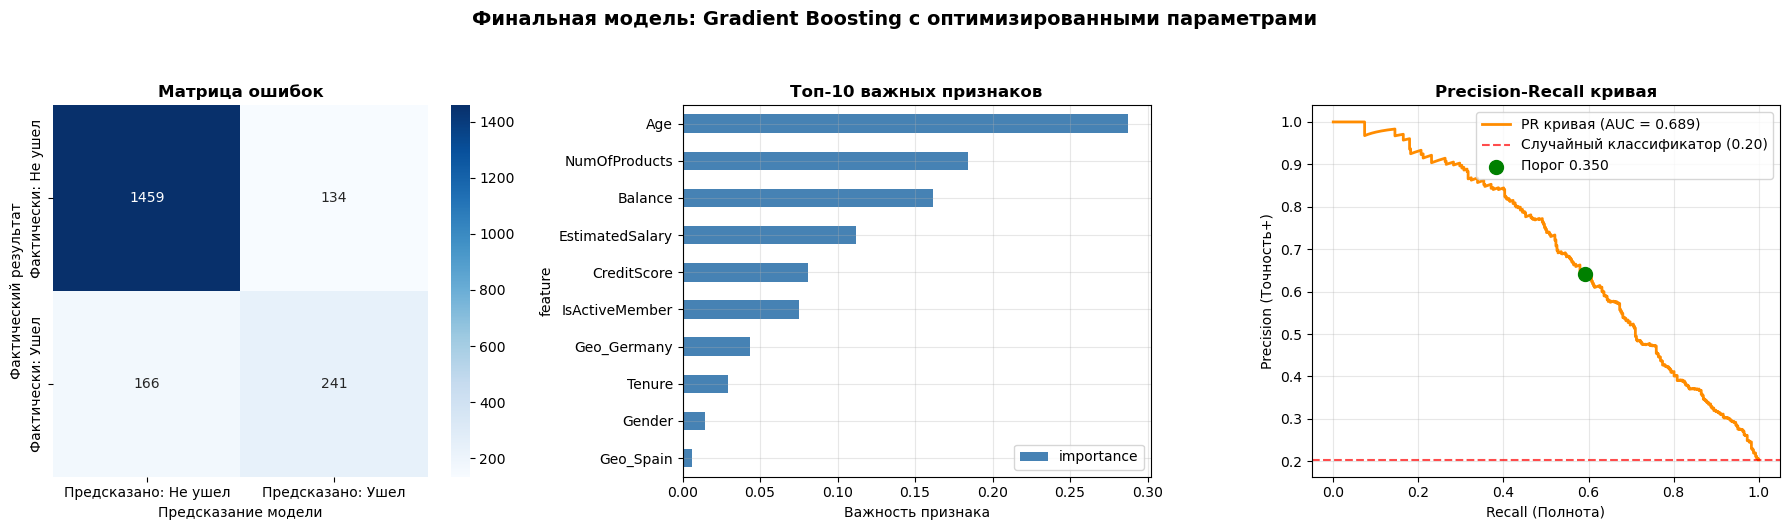

In [41]:
print(" ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ПРОЕКТА")
print("="*60)

print("\n ЛУЧШАЯ МОДЕЛЬ: Gradient Boosting")
print(" ЛУЧШИЕ ГИПЕРПАРАМЕТРЫ:")
for param, value in best_params.items():
    print(f"  • {param}: {value}")

print(f"\n ОПТИМАЛЬНЫЙ ПОРОГ КЛАССИФИКАЦИИ: {final_threshold:.3f}")
print("   (Выбран для баланса между Precision и Recall, вместо стандартного 0.5)")

print(f"\n📈 ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"  • Accuracy (Точность):    {final_metrics['accuracy']:.4f}")
print(f"  • Precision (Точность+):  {final_metrics['precision']:.4f} - из предсказанных 'уйдут', {final_metrics['precision']*100:.1f}% действительно уходят")
print(f"  • Recall (Полнота):       {final_metrics['recall']:.4f} - модель находит {final_metrics['recall']*100:.1f}% ушедших клиентов")
print(f"  • F1-score:               {final_metrics['f1']:.4f} - сбалансированная метрика")
print(f"  • F2-score:               {final_metrics['f2']:.4f} - с увеличенным весом Recall")


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Матрица ошибок
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Предсказано: Не ушел', 'Предсказано: Ушел'],
            yticklabels=['Фактически: Не ушел', 'Фактически: Ушел'])
axes[0].set_title('Матрица ошибок', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Предсказание модели', fontsize=10)
axes[0].set_ylabel('Фактический результат', fontsize=10)

#  Важность признаков
if hasattr(best_gb_model, 'feature_importances_'):
    importances = best_gb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    feature_importance_df.sort_values('importance').plot(
        kind='barh', x='feature', y='importance', ax=axes[1], color='steelblue'
    )
    axes[1].set_title('Топ-10 важных признаков', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Важность признака', fontsize=10)
    axes[1].grid(True, alpha=0.3)

# Precision-Recall кривая
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_gb)
axes[2].plot(recall_curve, precision_curve, color='darkorange', lw=2, 
             label=f'PR кривая (AUC = {pr_auc:.3f})')
axes[2].set_xlabel('Recall (Полнота)', fontsize=10)
axes[2].set_ylabel('Precision (Точность+)', fontsize=10)
axes[2].set_title('Precision-Recall кривая', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Линия для случайного классификатора
baseline = len(y_test[y_test==1]) / len(y_test)
axes[2].axhline(y=baseline, color='red', linestyle='--', alpha=0.7, 
                label=f'Случайный классификатор ({baseline:.2f})')
axes[2].legend(loc='upper right')

# Добавляем аннотацию с оптимальным порогом
axes[2].scatter(final_metrics['recall'], final_metrics['precision'], 
               color='green', s=100, zorder=5, label=f'Порог {final_threshold:.3f}')
axes[2].legend(loc='upper right')

plt.suptitle('Финальная модель: Gradient Boosting с оптимизированными параметрами', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()
